In [3]:
# OPTIONAL - sets the cells width of current notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [1]:
# import all necessary torch libraries
import torch
import torch.nn as nn
# sets output as wide as possible
torch.set_printoptions(edgeitems=30, linewidth=100000)
# data initialization
from dlc_practical_prologue import generate_pair_sets
nSamples = 1000

In [3]:
def visualize_accuracy_optim(train_accuracies, test_accuracies, lrs, title=None):
    std_train, train_accuracies = torch.std_mean(train_accuracies, dim=1)
    std_test, test_accuracies = torch.std_mean(test_accuracies, dim=1)
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7, 7))
    plt.xlabel('learning rate')
    plt.ylabel('accuracy(%)')
    nb_ticks = lrs.shape[0]
    plt.xticks(range(nb_ticks))
    plt.errorbar(lrs, train_accuracies, yerr=std_train, fmt='b-o', label="train")
    plt.errorbar(lrs, test_accuracies, yerr=std_test, fmt='g-o', label="test")
    plt.legend(loc="upper left")
    if title is not None:
        plt.savefig(title+'.png')
    plt.show()
    i_max = torch.argmax(torch.tensor(test_accuracies))
    print("Maxium test accuracy {:.2f} \u00B1 {:.2f} % for learning rate {:f}".format(test_accuracies[i_max],
                                                                                      std_test[i_max],
                                                                                      lrs[i_max]))

## ConvNet

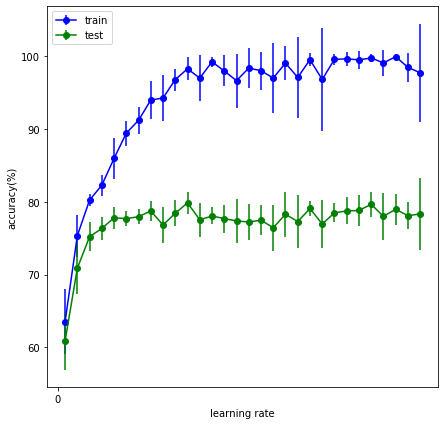

Maxium test accuracy 79.86 ± 1.50 % for learning rate 0.000179
CPU times: user 2h 19min 26s, sys: 1min 28s, total: 2h 20min 54s
Wall time: 36min 12s


<ipython-input-19-aea07a625f83>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  i_max = torch.argmax(torch.tensor(test_accuracies))


In [24]:
%%time

from models.convnet import ConvNet
from utils import train_model
from utils import visualize_accuracy

nb_epochs = 30
mini_batch_size = 100
lrs = torch.linspace(1e-5, 5e-4, 30)

# number of iterations for averaging result
nb_iters = 10

# optimization of learning parameter
train_accuracies = torch.empty(size=(lrs.shape[0], nb_iters))
test_accuracies = torch.empty(size=(lrs.shape[0], nb_iters))
for i in range(lrs.shape[0]):
    
    for j in range(nb_iters):
    
        # create model & optimizer
        model = ConvNet(nb_channels=24, kernel_size=3, weight_sharing=True)
        optimizer = torch.optim.Adam(model.parameters(), lr = lrs[i])
        #optimizer = torch.optim.SGD(model.parameters(), lr=lrs[i], momentum=0.1)
        criterion = nn.BCELoss()            

        # load data
        train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(nSamples)
        # pad input to size 16 x 16 (power of 2, so that it can be run through 3 max-pool layers)
        train_input_cnn = torch.nn.functional.pad(train_input, (1, 1, 1, 1), 'constant', 0)
        test_input_cnn = torch.nn.functional.pad(test_input, (1, 1, 1, 1), 'constant', 0)

        # train model
        train_accuracy, test_accuracy, _ = train_model(model, 
                                                       train_input_cnn, train_target.float(),
                                                       test_input_cnn, test_target,
                                                       nb_epochs, mini_batch_size,
                                                       optimizer, criterion)
        
        # add accuracy stats
        train_accuracies[i][j] = train_accuracy[0][-1] 
        test_accuracies[i][j] = test_accuracy[0][-1]
        
    
visualize_accuracy_optim(train_accuracies, test_accuracies, lrs, "ConvNet + weight sharing")

## Net1

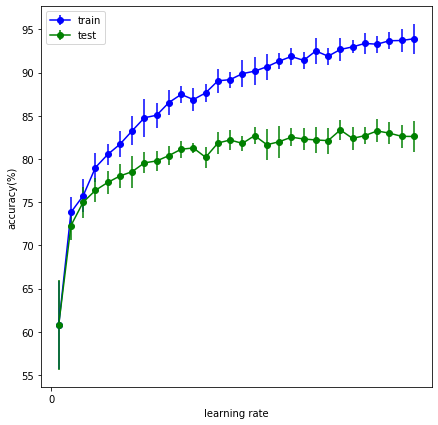

Maxium test accuracy 83.36 ± 1.13 % for learning rate 0.000399


<ipython-input-19-aea07a625f83>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  i_max = torch.argmax(torch.tensor(test_accuracies))


In [21]:
from utils import train_model
from utils import visualize_accuracy
from models.net1 import Net1

mini_batch_size = 100
nb_epochs = 10
lrs = torch.linspace(1e-5, 5e-4, 30)

# number of iterations for averaging result
nb_iters = 10

# optimization of learning parameter
train_accuracies = torch.empty(size=(lrs.shape[0], nb_iters))
test_accuracies = torch.empty(size=(lrs.shape[0], nb_iters))
for i in range(lrs.shape[0]):
    
    for j in range(nb_iters):

        # create model & optimizer
        model = Net1(weight_sharing = True)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = lrs[i])
        #optimizer = torch.optim.SGD(model.parameters(), lr=lrs[i], momentum=0.9)

        # load data
        train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(nSamples)

        # train model
        train_accuracy, test_accuracy, _ = train_model(model, 
                                                       train_input, train_target.float(),
                                                       test_input, test_target,
                                                       nb_epochs, mini_batch_size,
                                                       optimizer, criterion)

        # add accuracy stats
        train_accuracies[i][j] = train_accuracy[0][-1] 
        test_accuracies[i][j] = test_accuracy[0][-1]
    
visualize_accuracy_optim(train_accuracies, test_accuracies, lrs, "Net1 + weight sharing")

## Net2

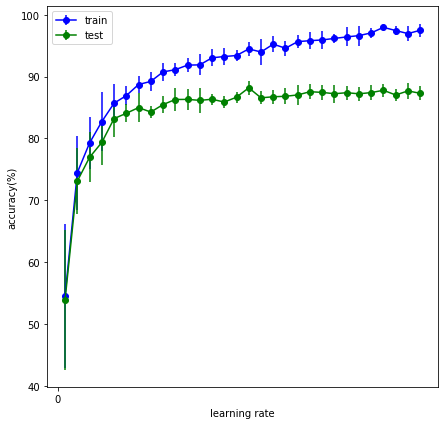

Maxium test accuracy 88.18 ± 1.18 % for learning rate 0.000263
CPU times: user 2h 54min 8s, sys: 1min 51s, total: 2h 55min 59s
Wall time: 45min 6s


<ipython-input-3-aea07a625f83>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  i_max = torch.argmax(torch.tensor(test_accuracies))


In [8]:
%%time

from utils import train_model
from utils import train_model_double_objective
from utils import accuracy_of_digit_class
from utils import dfs_freeze
from utils import calculate_mean_std
from models.net2 import Net2
from models.digit_classifier import DigitClassifier

# digit classifier params
mini_batch_size_dc = 100
eta_dc = 1e-3
nb_epochs_dc = 20
# net2 params
mini_batch_size = 100
nb_epochs = 25
lrs = torch.linspace(1e-5, 5e-4, 30)

# number of iterations for averaging result
nb_iters = 10

# optimization of learning parameter
train_accuracies = torch.empty(size=(lrs.shape[0], nb_iters))
test_accuracies = torch.empty(size=(lrs.shape[0], nb_iters))
for i in range(lrs.shape[0]):

    for j in range(nb_iters):
            
        # create digit classifier model & optimizer
        model_classifier = DigitClassifier(out_h = 10, subnet = False)
        optimizer = torch.optim.Adam(model_classifier.parameters(), lr = eta_dc)
        criterion = nn.CrossEntropyLoss()

        # load data
        train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(nSamples)

        # data for digit classifier
        train_in = train_input[:, 0, :, :].unsqueeze(axis = 1)
        train_class = train_classes[:,0]
        test_in = test_input[:, 0, :, :].unsqueeze(axis = 1)
        test_class = test_classes[:,0]

        # train digit classifier model
        train_accuracy_dc, test_accuracy_dc, train_loss_dc = train_model(model_classifier, 
                                                                         train_in, train_class,
                                                                         test_in, test_class,
                                                                         nb_epochs_dc, mini_batch_size_dc, 
                                                                         optimizer, criterion)

        model = Net2(pretrained_submodel = model_classifier)
        criterion = nn.BCEWithLogitsLoss()
        criterion2 = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = lrs[i])

        # load data
        #train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(nSamples)

        # train model
        train_accuracy, test_accuracy, _ = train_model_double_objective(model, train_input, train_target.float(), 
                                                         train_classes, test_input, test_target, 
                                                         test_classes, nb_epochs, mini_batch_size, optimizer, 
                                                         criterion, criterion2, beta = 1)
        
        # add accuracy stats
        train_accuracies[i][j] = train_accuracy[0][-1] 
        test_accuracies[i][j] = test_accuracy[0][-1]
    
visualize_accuracy_optim(train_accuracies, test_accuracies, lrs, 'Net2 + pre-trained dc')      